In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [64]:
import os
import sys
sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))
import random
from collections import defaultdict, namedtuple
import itertools
from abc import abstractmethod
from functools import lru_cache

import numpy as np
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas
import cv2

from IPython.display import display, Markdown, Latex

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
import tabulate

from quinn_embedding_stimuli import *
from quinn_embedding_models import *

In [3]:
RANDOM_SEED = 33
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = 'cpu'

## Object generator and sample

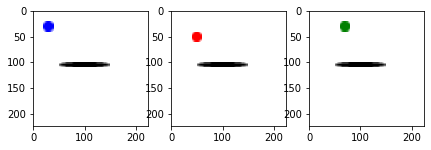

In [4]:
target_size = 20
reference_size = (10, 100)
reference_positions = [(105, 100)]

blue_target_patch = matplotlib.patches.Circle((0, 0), target_size // 2, color='blue')
red_target_patch = matplotlib.patches.Circle((0, 0), target_size // 2, color='red')
green_target_patch = matplotlib.patches.Circle((0, 0), target_size // 2, color='green')
reference_patch = matplotlib.patches.Ellipse((0, 0), width=reference_size[1], 
                                             height=reference_size[0], color='black')

blur_func = lambda x: cv2.blur(x, (5, 5))

# gen = NaiveStimulusGenerator(target_size, refernce_size, target_color='black', dtype=torch.float32)
gen = PatchStimulusGenerator(target_size, reference_size, [blue_target_patch, red_target_patch, green_target_patch], 
                             reference_patch, blur_func=blur_func)

plt.figure(figsize=(7, 3))

x = gen.generate((30, 30), reference_positions)
ax = plt.subplot(1, 3, 1)
ax.imshow(x.permute(1, 2, 0).numpy())

x = gen.generate((50, 50), reference_positions, target_index=1)
ax = plt.subplot(1, 3, 2)
ax.imshow(x.permute(1, 2, 0).numpy())

x = gen.generate((30, 70), reference_positions, target_index=2)
ax = plt.subplot(1, 3, 3)
ax.imshow(x.permute(1, 2, 0).numpy())

plt.show()

In [5]:
every = 5
half_target = target_size // 2
row_max = DEFAULT_CANVAS_SIZE[0] - half_target
col_max = DEFAULT_CANVAS_SIZE[1] - half_target
target_positions = [(r * every, c * every) for r, c 
                    in itertools.product(range(half_target // every, row_max // every), 
                                         range(half_target // every, col_max // every))]

# batch = gen.batch_generate(target_positions, reference_positions)
# batch.shape

In [6]:
miniature_stimuli_every = 20
row_max = DEFAULT_CANVAS_SIZE[0] - half_target
col_max = DEFAULT_CANVAS_SIZE[1] - half_target
miniature_target_positions = [(r * miniature_stimuli_every, c * miniature_stimuli_every) for r, c 
                                in itertools.product(range(1, 
                                                           row_max // miniature_stimuli_every + 1), 
                                                     range(1, 
                                                           col_max // miniature_stimuli_every + 1))]
# miniature_target_positions
# miniature_batch = gen.batch_generate(miniature_target_positions, reference_positions)
# miniature_batch.shape

## Triplet generators

In [125]:
TRIPLET_CACHE_SIZE = 16

class TripletGenerator:
    def __init__(self, stimulus_generator, 
                 two_reference_objects=False, two_targets_between=True, n_target_colors=1,
                 transpose=False, vertical_margin=0, horizontal_margin=0, seed=RANDOM_SEED, use_tqdm=False):
        self.stimulus_generator = stimulus_generator
        self.two_reference_objects = two_reference_objects
        self.two_targets_between = two_targets_between
        self.n_target_colors = n_target_colors
        
        if n_target_colors > self.stimulus_generator.n_targets:
            raise ValueError(f'Expected n_target_colors={n_target_colors} <= self.stimulus_generator.n_targets={self.stimulus_generator.n_targets}')
        
        self.transpose = transpose
        self.vertical_margin = vertical_margin
        self.horizontal_margin = horizontal_margin
        self.seed = seed
        self.rng = np.random.default_rng(self.seed)
        self.use_tqdm = use_tqdm
        
    @lru_cache(maxsize=TRIPLET_CACHE_SIZE)
    def __call__(self, n=1, normalize=True, seed=None):
        if seed is None:
            seed = self.seed
            
        self.rng = np.random.default_rng(self.seed)
        n_iter = range(n)
        if self.use_tqdm:
            n_iter = tqdm(range(n), desc='Data Generation')
        
        results = [self.generate_single_triplet(normalize=normalize)for _ in n_iter]   
        result_tensor = torch.stack(results)
        
        if self.transpose:
            return result_tensor.permute(0, 1, 2, 4, 3)
        
        return result_tensor
    
    @abstractmethod
    def generate_single_triplet(self, normalize=True):
        pass
    

class EquilateralTripletGenerator(TripletGenerator):
    def __init__(self, stimulus_generator, side_length_endpoints, 
                 target_margin_from_reference_edge=0, pair_above=None,
                 two_reference_objects=False, two_targets_between=True, 
                 n_target_colors=1, transpose=False, 
                 vertical_margin=0, horizontal_margin=0, 
                 seed=RANDOM_SEED, use_tqdm=False):
        super(EquilateralTripletGenerator, self).__init__(
            stimulus_generator=stimulus_generator, 
            two_reference_objects=two_reference_objects,
            two_targets_between=two_targets_between, n_target_colors=n_target_colors,
            transpose=transpose, vertical_margin=vertical_margin,
            horizontal_margin=horizontal_margin, seed=seed, use_tqdm=use_tqdm)
        
        if not hasattr(side_length_endpoints, '__len__'):
            side_length_endpoints = (side_length_endpoints, side_length_endpoints)
            
        self.side_length_endpoints = side_length_endpoints
        self.target_margin_from_reference_edge = target_margin_from_reference_edge
        self.pair_above = pair_above
        
    def generate_single_triplet(self, normalize=True):
        side_length = self.rng.integers(*self.side_length_endpoints)
        height = (3 ** 0.5) * side_length / 2
        half_height = height // 2
        if self.two_reference_objects:
            min_vertical_margin = height + (self.stimulus_generator.reference_size[0] // 2) + 1
        else:
            min_vertical_margin = half_height + (self.stimulus_generator.target_size[0] // 2) + 1

        vertical_margin = max(min_vertical_margin, self.vertical_margin)
        horizontal_margin = max(self.stimulus_generator.reference_size[1] // 2 + 1, self.horizontal_margin)

        reference_center_position = np.array(
            (self.rng.integers(vertical_margin, self.stimulus_generator.canvas_size[0] - vertical_margin),
             self.rng.integers(horizontal_margin, self.stimulus_generator.canvas_size[1] - horizontal_margin)), 
            dtype=np.int)

        target_margin = (self.stimulus_generator.reference_size[1] - self.stimulus_generator.target_size[1]) // 2
        left_target_horizontal_offset = self.rng.integers(-target_margin, target_margin - side_length)
        middle_target_horizontal_offset = left_target_horizontal_offset + side_length // 2
        right_target_horizontal_offset = left_target_horizontal_offset + side_length

        if self.pair_above is None:
            pair_above = np.sign(self.rng.uniform(-0.5, 0.5))
        else:
            pair_above = self.pair_above and 1 or -1

        left_target_offset = np.array((pair_above * half_height, left_target_horizontal_offset), dtype=np.int)
        middle_target_offset = np.array((-1 * pair_above * half_height, middle_target_horizontal_offset), dtype=np.int)
        right_target_offset = np.array((pair_above * half_height, right_target_horizontal_offset), dtype=np.int)

        target_positions = [tuple(reference_center_position + offset) for offset in 
                            (left_target_offset, right_target_offset, middle_target_offset)]

        if self.two_reference_objects:
            second_reference_center = np.copy(reference_center_position)
            two_targets_between = self.two_targets_between and 1 or -1
            second_reference_vertical_direction = pair_above * two_targets_between
            second_reference_center[0] += second_reference_vertical_direction * height
            reference_center_position = [reference_center_position, second_reference_center]
            
        target_indices = (0, 0, 0)
        if self.n_target_colors == 2:
            pair_color = self.rng.uniform() > 0.5
            single_color = 1 - pair_color
            if self.rng.uniform() > 0.5:
                target_indices = (pair_color, single_color, pair_color)
            else:
                target_indices = (single_color, pair_color, pair_color)
        elif self.n_target_colors == 3:
            target_indices = [0, 1, 2]
            self.rng.shuffle(target_indices)
            target_indices = tuple(target_indices)
            
#         if second_reference_center[0] <= (self.stimulus_generator.reference_size[0] // 2) or \
#             second_reference_center[0] >= (223 - (self.stimulus_generator.reference_size[0] // 2)) or \
#             second_reference_center[1] <= (self.stimulus_generator.reference_size[1] // 2) or \
#             second_reference_center[0] >= (223 - (self.stimulus_generator.reference_size[0] // 2)):
            
#             print(reference_center_position)
#             print(side_length, height, half_height, horizontal_margin, vertical_margin)
        
        return self.stimulus_generator.batch_generate(target_positions, reference_center_position, target_indices, normalize=normalize)
    
    
class QuinnTripletGenerator(TripletGenerator):
    def __init__(self, stimulus_generator, distance_endpoints, 
                 target_margin_from_reference_edge=0, pair_above=None, two_objects_left=None,
                 two_reference_objects=False, two_targets_between=True, 
                 n_target_colors=1, transpose=False,
                 vertical_margin=0, horizontal_margin=0,
                 seed=RANDOM_SEED, use_tqdm=False):
        super(QuinnTripletGenerator, self).__init__(
            stimulus_generator=stimulus_generator, 
            two_reference_objects=two_reference_objects,
            two_targets_between=two_targets_between, n_target_colors=n_target_colors,
            transpose=transpose, vertical_margin=vertical_margin, 
            horizontal_margin=horizontal_margin, seed=seed, use_tqdm=use_tqdm)
        
        if not hasattr(distance_endpoints, '__len__'):
            distance_endpoints = (distance_endpoints, distance_endpoints)
            
        self.distance_endpoints = distance_endpoints        
        self.target_margin_from_reference_edge = target_margin_from_reference_edge
        self.pair_above = pair_above
        self.two_objects_left = two_objects_left
    
    def generate_single_triplet(self, normalize=True):
        distance = self.rng.integers(*self.distance_endpoints)
        half_distance = distance // 2
        if self.two_reference_objects:
            min_vertical_margin = distance + (self.stimulus_generator.reference_size[0] // 2) + 1
        else:
            min_vertical_margin = half_distance + (self.stimulus_generator.target_size[0] // 2) + 1

        vertical_margin = max(min_vertical_margin, self.vertical_margin)
        horizontal_margin = max(self.stimulus_generator.reference_size[1] // 2 + 1, self.horizontal_margin)

        reference_center_position = np.array(
            (self.rng.integers(vertical_margin, self.stimulus_generator.canvas_size[0] - vertical_margin),
             self.rng.integers(horizontal_margin, self.stimulus_generator.canvas_size[1] - horizontal_margin)), 
            dtype=np.int)

        target_margin = (self.stimulus_generator.reference_size[1] - self.stimulus_generator.target_size[1]) // 2
        left_target_horizontal_offset = self.rng.integers(-target_margin, target_margin - distance)
        right_target_horizontal_offset = left_target_horizontal_offset + distance

        if self.pair_above is None:
            pair_above = np.sign(self.rng.uniform(-0.5, 0.5))
        else:
            pair_above = self.pair_above and 1 or -1

        two_objects_left = self.two_objects_left
        if two_objects_left is None:
            two_objects_left = self.rng.uniform() > 0.5

        left_target_offset = np.array((pair_above * half_distance, left_target_horizontal_offset), dtype=np.int)
        right_target_offset = np.array((pair_above * half_distance, right_target_horizontal_offset), dtype=np.int)
        other_side_target_offset = np.array((-pair_above * half_distance, two_objects_left and left_target_horizontal_offset or right_target_horizontal_offset), dtype=np.int)

        target_positions = [tuple(reference_center_position + offset) for offset in 
                            (left_target_offset, right_target_offset, other_side_target_offset)]
        
        if self.two_reference_objects:
            second_reference_center = np.copy(reference_center_position)
            two_targets_between = self.two_targets_between and 1 or -1
            second_reference_vertical_direction = pair_above * two_targets_between
            second_reference_center[0] += second_reference_vertical_direction * distance
            reference_center_position = [reference_center_position, second_reference_center]
            
        target_indices = (0, 0, 0)
        if self.n_target_colors == 2:
            pair_color = self.rng.uniform() > 0.5
            single_color = 1 - pair_color
            if two_objects_left:
                target_indices = (single_color, pair_color, pair_color)
            else:
                target_indices = (pair_color, single_color, pair_color)
        elif self.n_target_colors == 3:
            target_indices = [0, 1, 2]
            self.rng.shuffle(target_indices)
            target_indices = tuple(target_indices)

        return self.stimulus_generator.batch_generate(target_positions, reference_center_position, target_indices, normalize=normalize)


* Above/Below vs. Between
* Quinn (isocseles) vs. Equilateral
* Horizontal or vertical
* # colors

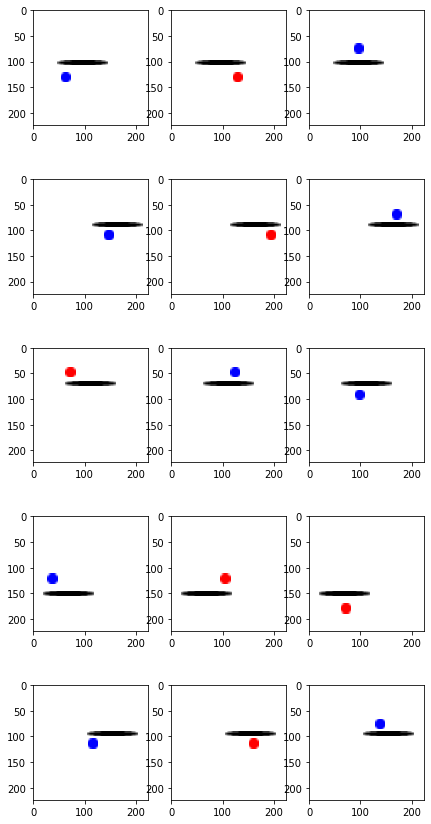

In [126]:
N = 5

above_below_equilateral_gen = EquilateralTripletGenerator(gen, (40, 70), n_target_colors=2)
results = above_below_equilateral_gen(N, normalize=False)
plt.figure(figsize=(7, 3 * N))

for row in range(N):
    for col in range(3):
        ax = plt.subplot(N, 3, (3 * row) + col + 1)
        ax.imshow(results[row, col].permute(1, 2, 0).numpy())

plt.show()


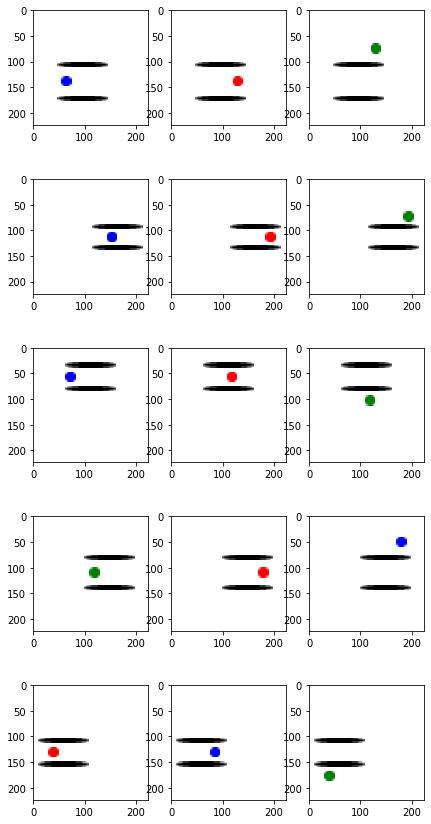

In [127]:
N = 5

above_below_quinn_gen = QuinnTripletGenerator(gen, (30, 70), two_reference_objects=True, n_target_colors=3)
results = above_below_quinn_gen(N, normalize=False)
plt.figure(figsize=(7, 3 * N))

for row in range(N):
    for col in range(3):
        ax = plt.subplot(N, 3, (3 * row) + col + 1)
        ax.imshow(results[row, col].permute(1, 2, 0).numpy())

plt.show()


## Metric functions

In [128]:
class Metric:
    def __init__(self, name, correct_index=0):
        self.name = name
        self.correct_index = correct_index
        
    @abstractmethod
    def __call__(self, pairwise_cosines):
        pass
    
    def aggregate(self, result_list):
        if isinstance(result_list[0], torch.Tensor):
            return torch.cat(result_list).detach().cpu().numpy()
        
        if isinstance(result_list[0], np.ndarray):
            return np.concatenate(result_list)
        
        raise ValueError(f'Can only combine lists of torch.Tensor or np.ndarray, received {type(result_list[0])}')

        
class AccuracyMetric(Metric):
    def __init__(self, name, correct_index=0):
        super(AccuracyMetric, self).__init__(name, correct_index)
        
    def __call__(self, pairwise_cosines):
        return (pairwise_cosines.argmax(dim=1) == self.correct_index).to(torch.float)
        
        
class DifferenceMetric(Metric):
    def __init__(self, name, correct_index=0, combine_func=torch.mean,
                 combine_func_kwargs=dict(dim=1)):
        super(DifferenceMetric, self).__init__(name, correct_index)
        self.combine_func = combine_func
        self.incorrect_indices = list(range(3))
        self.incorrect_indices.remove(correct_index)
        self.combine_func_kwargs = combine_func_kwargs
        
    def __call__(self, pairwise_cosines):
        return pairwise_cosines[:, self.correct_index] - self.combine_func(pairwise_cosines[:, self.incorrect_indices], **self.combine_func_kwargs)
    
    
METRICS = (AccuracyMetric('Accuracy'), DifferenceMetric('MeanDiff'),
           DifferenceMetric('MaxDiff', combine_func=lambda x: torch.max(x, dim=1).values, combine_func_kwargs={}))

## Actual task implementation

In [129]:
TaskResults = namedtuple('TaskResults', ('mean', 'std', 'n'))

BATCH_SIZE = 64

def quinn_embedding_task_single_generator(
    model, triplet_generator, metrics=METRICS, N=1024, batch_size=BATCH_SIZE, use_tqdm=False):
    
    data = triplet_generator(N)
    B = batch_size
    dataloader = DataLoader(TensorDataset(data), batch_size=batch_size, shuffle=False)
    
    model_results = defaultdict(list)
    cos = nn.CosineSimilarity(dim=-1)
    triangle_indices = np.triu_indices(3, 1)
    
    model.eval()
    
    data_iter = dataloader
    if use_tqdm:
        data_iter = tqdm(dataloader, desc='Batches')
        
    for b in data_iter:
        x = b[0]  # shape (B, 3, 3, 224, 224)
        x = x.view(-1, *x.shape[2:])
        e = model(x.to(device)).detach().cpu()
        e = e.view(B, 3, -1)  # shape (B, 3, Z)

        embedding_pairwise_cosine = cos(e[:, :, None, :], e[:, None, :, :])  # shape (B, 3, 3)
        triplet_cosines = embedding_pairwise_cosine[:, triangle_indices[0], triangle_indices[1]] # shape (B, 3)

        for metric in metrics:
            model_results[metric.name].append(metric(triplet_cosines))

    for metric in metrics:
        model_results[metric.name] = metric.aggregate(model_results[metric.name])

    return model_results

def quinn_embedding_task_multiple_generators(
    model_name, model, triplet_generators, condition_names, 
    metrics=METRICS, N=1024, batch_size=BATCH_SIZE):
    
    headers = ['ConditionNames'] + [metric.name for metric in metrics]
    all_results = {}
    for name, triplet_gen in zip(condition_names, triplet_generators):
        results = quinn_embedding_task_single_generator(model, triplet_gen, metrics=metrics,
                                                        N=N, batch_size=batch_size)
        all_results[name] = {metric.name: TaskResults(np.mean(results[metric.name]), 
                                                      np.std(results[metric.name]), N) 
                             for metric in metrics}
    return all_results
    

In [130]:
QUINN_DISTANCE_ENDPOINTS = (30, 70)

quinn_triplet_generators = []
quinn_names = []

for two_reference_objects in (False, True):
    for transpose in (False, True):
        for n_target_colors in range(1, 4):
            qtg = QuinnTripletGenerator(gen, QUINN_DISTANCE_ENDPOINTS,  
                                        two_reference_objects=two_reference_objects,
                                        transpose=transpose,
                                        n_target_colors=n_target_colors)
            quinn_triplet_generators.append(qtg)
            if two_reference_objects:
                if transpose:
                    rel_name = 'Between-sideways'
                else:
                    rel_name = 'Between'
            else:
                if transpose:
                    rel_name = 'Left/Right'
                else:
                    rel_name = 'Above/Below'
                
            quinn_names.append(f'Quinn-{rel_name}-{n_target_colors}-colors')

In [131]:
model_kwarg_dicts = (
    dict(name=MOBILENET, device=device, pretrained=False, saycam='SAY'),
    dict(name=MOBILENET, device=device, pretrained=True),
    dict(name=MOBILENET, device=device, pretrained=False),
    dict(name=RESNEXT, device=device, pretrained=False, saycam='SAY'),
    dict(name=RESNEXT, device=device, pretrained=True),
    dict(name=RESNEXT, device=device, pretrained=False),
)

model_names = [ f'{d["name"]}-{"saycam" in d and "saycam" or (d["pretrained"] and "imagenet" or "random")}'
               for d in model_kwarg_dicts]


In [132]:
N = 256
quinn_generators_all_model_results = {}

for name, model_kwargs in zip (model_names, model_kwarg_dicts):
    print(f'Starting model {name}')
    model = build_model(**model_kwargs)
    
    quinn_generators_all_model_results[name] = quinn_embedding_task_multiple_generators(
        name, model, quinn_triplet_generators, quinn_names, N=N)

    del model

Starting model mobilenet-saycam
Starting model mobilenet-imagenet
Starting model mobilenet-random
Starting model resnext-saycam
Starting model resnext-imagenet
Starting model resnext-random


In [133]:
EQUILATERAL_DISTANCE_ENDPOINTS = (40, 70)

equilateral_triplet_generators = []
equilateral_names = []

for two_reference_objects in (False, True):
    for transpose in (False, True):
        for n_target_colors in range(1, 4):
            etg = EquilateralTripletGenerator(gen, EQUILATERAL_DISTANCE_ENDPOINTS,  
                                              two_reference_objects=two_reference_objects,
                                              transpose=transpose,
                                              n_target_colors=n_target_colors)
            equilateral_triplet_generators.append(etg)
            if two_reference_objects:
                if transpose:
                    rel_name = 'Between-sideways'
                else:
                    rel_name = 'Between'
            else:
                if transpose:
                    rel_name = 'Left/Right'
                else:
                    rel_name = 'Above/Below'
                
            equilateral_names.append(f'Equilateral-{rel_name}-{n_target_colors}-colors')

In [134]:
N = 256
equilateral_generators_all_model_results = {}

for name, model_kwargs in zip (model_names, model_kwarg_dicts):
    print(f'Starting model {name}')
    model = build_model(**model_kwargs)
    
    equilateral_generators_all_model_results[name] = quinn_embedding_task_multiple_generators(
        name, model, equilateral_triplet_generators, equilateral_names, N=N)

    del model

Starting model mobilenet-saycam
Starting model mobilenet-imagenet
Starting model mobilenet-random
Starting model resnext-saycam
Starting model resnext-imagenet
Starting model resnext-random


In [135]:
def format_results(task_results):
    return f'${task_results.mean:.4f} \\pm {task_results.std / (task_results.n ** 0.5):.4f}$'


def display_multiple_model_results(group_name, results, tablefmt='simple'):
    display(Markdown(f'## {group_name} Results'))
        
    key_groups = set([key[:-9] for key in next(iter(results.values())).keys()])
    metric_names = tuple(next(iter(next(iter(quinn_generators_all_model_results.values())).values())).keys())
    headers = ['# Colors', 'Model'] + [name + '&nbsp; ' * 12 for name in metric_names]
    
    for key_group in key_groups:
        display(Markdown(f'### {key_group}'))
        
        rows = []
        
        for n_colors in range(1, 4):
            key = f'{key_group}-{n_colors}-colors'
            for model_name, model_results in results.items():
                rows.append([n_colors, model_name] + [format_results(model_results[key][metric_name])
                                                      for metric_name in metric_names])
                
        display(Markdown(tabulate.tabulate(rows, headers, tablefmt=tablefmt)))

        

In [136]:
display_multiple_model_results('Quinn', quinn_generators_all_model_results, tablefmt='github')

## Quinn Results

### Quinn-Between-sideways

|   # Colors | Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | MeanDiff&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | MaxDiff&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------|--------------------|------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|
|          1 | mobilenet-saycam   | $0.5195 \pm 0.0312$                                                                            | $0.0075 \pm 0.0006$                                                                            | $-0.0009 \pm 0.0007$                                                                          |
|          1 | mobilenet-imagenet | $0.3828 \pm 0.0304$                                                                            | $0.0089 \pm 0.0009$                                                                            | $-0.0018 \pm 0.0010$                                                                          |
|          1 | mobilenet-random   | $0.1953 \pm 0.0248$                                                                            | $-0.0000 \pm 0.0000$                                                                           | $-0.0000 \pm 0.0000$                                                                          |
|          1 | resnext-saycam     | $0.2695 \pm 0.0277$                                                                            | $0.0019 \pm 0.0008$                                                                            | $-0.0109 \pm 0.0010$                                                                          |
|          1 | resnext-imagenet   | $0.0547 \pm 0.0142$                                                                            | $-0.0199 \pm 0.0012$                                                                           | $-0.0371 \pm 0.0014$                                                                          |
|          1 | resnext-random     | $0.5039 \pm 0.0312$                                                                            | $0.0000 \pm 0.0000$                                                                            | $0.0000 \pm 0.0000$                                                                           |
|          2 | mobilenet-saycam   | $0.6914 \pm 0.0289$                                                                            | $0.0103 \pm 0.0006$                                                                            | $0.0047 \pm 0.0007$                                                                           |
|          2 | mobilenet-imagenet | $0.0898 \pm 0.0179$                                                                            | $-0.0097 \pm 0.0009$                                                                           | $-0.0214 \pm 0.0010$                                                                          |
|          2 | mobilenet-random   | $0.2227 \pm 0.0260$                                                                            | $-0.0000 \pm 0.0000$                                                                           | $-0.0000 \pm 0.0000$                                                                          |
|          2 | resnext-saycam     | $0.3125 \pm 0.0290$                                                                            | $0.0023 \pm 0.0008$                                                                            | $-0.0093 \pm 0.0009$                                                                          |
|          2 | resnext-imagenet   | $0.0117 \pm 0.0067$                                                                            | $-0.0495 \pm 0.0014$                                                                           | $-0.0645 \pm 0.0016$                                                                          |
|          2 | resnext-random     | $0.2266 \pm 0.0262$                                                                            | $-0.0000 \pm 0.0000$                                                                           | $-0.0000 \pm 0.0000$                                                                          |
|          3 | mobilenet-saycam   | $0.6719 \pm 0.0293$                                                                            | $0.0114 \pm 0.0006$                                                                            | $0.0041 \pm 0.0007$                                                                           |
|          3 | mobilenet-imagenet | $0.3398 \pm 0.0296$                                                                            | $0.0068 \pm 0.0011$                                                                            | $-0.0068 \pm 0.0014$                                                                          |
|          3 | mobilenet-random   | $0.1992 \pm 0.0250$                                                                            | $-0.0000 \pm 0.0000$                                                                           | $-0.0000 \pm 0.0000$                                                                          |
|          3 | resnext-saycam     | $0.2773 \pm 0.0280$                                                                            | $0.0011 \pm 0.0009$                                                                            | $-0.0105 \pm 0.0010$                                                                          |
|          3 | resnext-imagenet   | $0.0430 \pm 0.0127$                                                                            | $-0.0278 \pm 0.0015$                                                                           | $-0.0468 \pm 0.0018$                                                                          |
|          3 | resnext-random     | $0.3711 \pm 0.0302$                                                                            | $0.0000 \pm 0.0000$                                                                            | $-0.0000 \pm 0.0000$                                                                          |

### Quinn-Above/Below

|   # Colors | Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | MeanDiff&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | MaxDiff&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------|--------------------|------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|
|          1 | mobilenet-saycam   | $1.0000 \pm 0.0000$                                                                            | $0.0903 \pm 0.0012$                                                                            | $0.0819 \pm 0.0013$                                                                           |
|          1 | mobilenet-imagenet | $0.9688 \pm 0.0109$                                                                            | $0.0512 \pm 0.0014$                                                                            | $0.0424 \pm 0.0015$                                                                           |
|          1 | mobilenet-random   | $0.3828 \pm 0.0304$                                                                            | $-0.0000 \pm 0.0000$                                                                           | $-0.0000 \pm 0.0000$                                                                          |
|          1 | resnext-saycam     | $1.0000 \pm 0.0000$                                                                            | $0.1291 \pm 0.0017$                                                                            | $0.1214 \pm 0.0017$                                                                           |
|          1 | resnext-imagenet   | $0.9219 \pm 0.0168$                                                                            | $0.0512 \pm 0.0020$                                                                            | $0.0398 \pm 0.0021$                                                                           |
|          1 | resnext-random     | $0.5352 \pm 0.0312$                                                                            | $0.0000 \pm 0.0000$                                                                            | $0.0000 \pm 0.0000$                                                                           |
|          2 | mobilenet-saycam   | $1.0000 \pm 0.0000$                                                                            | $0.0745 \pm 0.0011$                                                                            | $0.0658 \pm 0.0012$                                                                           |
|          2 | mobilenet-imagenet | $0.5977 \pm 0.0306$                                                                            | $0.0232 \pm 0.0017$                                                                            | $0.0079 \pm 0.0018$                                                                           |
|          2 | mobilenet-random   | $0.3125 \pm 0.0290$                                                                            | $-0.0000 \pm 0.0000$                                                                           | $-0.0000 \pm 0.0000$                                                                          |
|          2 | resnext-saycam     | $1.0000 \pm 0.0000$                                                                            | $0.1337 \pm 0.0017$                                                                            | $0.1253 \pm 0.0018$                                                                           |
|          2 | resnext-imagenet   | $0.2422 \pm 0.0268$                                                                            | $0.0002 \pm 0.0025$                                                                            | $-0.0225 \pm 0.0028$                                                                          |
|          2 | resnext-random     | $0.2734 \pm 0.0279$                                                                            | $-0.0000 \pm 0.0000$                                                                           | $-0.0000 \pm 0.0000$                                                                          |
|          3 | mobilenet-saycam   | $1.0000 \pm 0.0000$                                                                            | $0.0778 \pm 0.0014$                                                                            | $0.0682 \pm 0.0016$                                                                           |
|          3 | mobilenet-imagenet | $0.7344 \pm 0.0276$                                                                            | $0.0410 \pm 0.0020$                                                                            | $0.0250 \pm 0.0023$                                                                           |
|          3 | mobilenet-random   | $0.3984 \pm 0.0306$                                                                            | $0.0000 \pm 0.0000$                                                                            | $-0.0000 \pm 0.0000$                                                                          |
|          3 | resnext-saycam     | $1.0000 \pm 0.0000$                                                                            | $0.1220 \pm 0.0018$                                                                            | $0.1123 \pm 0.0019$                                                                           |
|          3 | resnext-imagenet   | $0.6250 \pm 0.0303$                                                                            | $0.0253 \pm 0.0021$                                                                            | $0.0091 \pm 0.0024$                                                                           |
|          3 | resnext-random     | $0.3906 \pm 0.0305$                                                                            | $0.0000 \pm 0.0000$                                                                            | $-0.0000 \pm 0.0000$                                                                          |

### Quinn-Left/Right

|   # Colors | Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | MeanDiff&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | MaxDiff&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------|--------------------|------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|
|          1 | mobilenet-saycam   | $0.5469 \pm 0.0311$                                                                            | $0.0138 \pm 0.0008$                                                                            | $0.0017 \pm 0.0010$                                                                           |
|          1 | mobilenet-imagenet | $0.3281 \pm 0.0293$                                                                            | $0.0079 \pm 0.0009$                                                                            | $-0.0073 \pm 0.0010$                                                                          |
|          1 | mobilenet-random   | $0.3672 \pm 0.0301$                                                                            | $-0.0000 \pm 0.0000$                                                                           | $-0.0000 \pm 0.0000$                                                                          |
|          1 | resnext-saycam     | $0.0273 \pm 0.0102$                                                                            | $-0.0062 \pm 0.0007$                                                                           | $-0.0243 \pm 0.0009$                                                                          |
|          1 | resnext-imagenet   | $0.0820 \pm 0.0172$                                                                            | $-0.0072 \pm 0.0013$                                                                           | $-0.0301 \pm 0.0014$                                                                          |
|          1 | resnext-random     | $0.5781 \pm 0.0309$                                                                            | $0.0000 \pm 0.0000$                                                                            | $0.0000 \pm 0.0000$                                                                           |
|          2 | mobilenet-saycam   | $0.5352 \pm 0.0312$                                                                            | $0.0074 \pm 0.0008$                                                                            | $0.0014 \pm 0.0009$                                                                           |
|          2 | mobilenet-imagenet | $0.0977 \pm 0.0186$                                                                            | $-0.0198 \pm 0.0013$                                                                           | $-0.0324 \pm 0.0014$                                                                          |
|          2 | mobilenet-random   | $0.2812 \pm 0.0281$                                                                            | $-0.0000 \pm 0.0000$                                                                           | $-0.0000 \pm 0.0000$                                                                          |
|          2 | resnext-saycam     | $0.0078 \pm 0.0055$                                                                            | $-0.0063 \pm 0.0007$                                                                           | $-0.0236 \pm 0.0008$                                                                          |
|          2 | resnext-imagenet   | $0.1055 \pm 0.0192$                                                                            | $-0.0331 \pm 0.0020$                                                                           | $-0.0470 \pm 0.0023$                                                                          |
|          2 | resnext-random     | $0.2734 \pm 0.0279$                                                                            | $-0.0000 \pm 0.0000$                                                                           | $-0.0000 \pm 0.0000$                                                                          |
|          3 | mobilenet-saycam   | $0.5312 \pm 0.0312$                                                                            | $0.0103 \pm 0.0009$                                                                            | $-0.0003 \pm 0.0011$                                                                          |
|          3 | mobilenet-imagenet | $0.4023 \pm 0.0306$                                                                            | $0.0046 \pm 0.0017$                                                                            | $-0.0103 \pm 0.0018$                                                                          |
|          3 | mobilenet-random   | $0.3320 \pm 0.0294$                                                                            | $-0.0000 \pm 0.0000$                                                                           | $-0.0000 \pm 0.0000$                                                                          |
|          3 | resnext-saycam     | $0.0781 \pm 0.0168$                                                                            | $-0.0064 \pm 0.0008$                                                                           | $-0.0233 \pm 0.0010$                                                                          |
|          3 | resnext-imagenet   | $0.2109 \pm 0.0255$                                                                            | $-0.0087 \pm 0.0019$                                                                           | $-0.0305 \pm 0.0022$                                                                          |
|          3 | resnext-random     | $0.3711 \pm 0.0302$                                                                            | $0.0000 \pm 0.0000$                                                                            | $-0.0000 \pm 0.0000$                                                                          |

### Quinn-Between

|   # Colors | Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | MeanDiff&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | MaxDiff&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------|--------------------|------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|
|          1 | mobilenet-saycam   | $1.0000 \pm 0.0000$                                                                            | $0.0393 \pm 0.0008$                                                                            | $0.0326 \pm 0.0009$                                                                           |
|          1 | mobilenet-imagenet | $0.9609 \pm 0.0121$                                                                            | $0.0342 \pm 0.0011$                                                                            | $0.0278 \pm 0.0012$                                                                           |
|          1 | mobilenet-random   | $0.2734 \pm 0.0279$                                                                            | $-0.0000 \pm 0.0000$                                                                           | $-0.0000 \pm 0.0000$                                                                          |
|          1 | resnext-saycam     | $1.0000 \pm 0.0000$                                                                            | $0.0454 \pm 0.0010$                                                                            | $0.0375 \pm 0.0011$                                                                           |
|          1 | resnext-imagenet   | $0.6523 \pm 0.0298$                                                                            | $0.0181 \pm 0.0012$                                                                            | $0.0076 \pm 0.0014$                                                                           |
|          1 | resnext-random     | $0.4805 \pm 0.0312$                                                                            | $0.0000 \pm 0.0000$                                                                            | $-0.0000 \pm 0.0000$                                                                          |
|          2 | mobilenet-saycam   | $0.9570 \pm 0.0127$                                                                            | $0.0332 \pm 0.0008$                                                                            | $0.0271 \pm 0.0009$                                                                           |
|          2 | mobilenet-imagenet | $0.4727 \pm 0.0312$                                                                            | $0.0120 \pm 0.0012$                                                                            | $0.0012 \pm 0.0011$                                                                           |
|          2 | mobilenet-random   | $0.2266 \pm 0.0262$                                                                            | $-0.0000 \pm 0.0000$                                                                           | $-0.0000 \pm 0.0000$                                                                          |
|          2 | resnext-saycam     | $0.9727 \pm 0.0102$                                                                            | $0.0454 \pm 0.0010$                                                                            | $0.0369 \pm 0.0012$                                                                           |
|          2 | resnext-imagenet   | $0.0312 \pm 0.0109$                                                                            | $-0.0221 \pm 0.0016$                                                                           | $-0.0431 \pm 0.0018$                                                                          |
|          2 | resnext-random     | $0.2461 \pm 0.0269$                                                                            | $-0.0000 \pm 0.0000$                                                                           | $-0.0000 \pm 0.0000$                                                                          |
|          3 | mobilenet-saycam   | $0.9531 \pm 0.0132$                                                                            | $0.0361 \pm 0.0009$                                                                            | $0.0294 \pm 0.0010$                                                                           |
|          3 | mobilenet-imagenet | $0.7539 \pm 0.0269$                                                                            | $0.0276 \pm 0.0016$                                                                            | $0.0184 \pm 0.0018$                                                                           |
|          3 | mobilenet-random   | $0.2539 \pm 0.0272$                                                                            | $-0.0000 \pm 0.0000$                                                                           | $-0.0000 \pm 0.0000$                                                                          |
|          3 | resnext-saycam     | $0.9453 \pm 0.0142$                                                                            | $0.0422 \pm 0.0011$                                                                            | $0.0332 \pm 0.0012$                                                                           |
|          3 | resnext-imagenet   | $0.2383 \pm 0.0266$                                                                            | $-0.0012 \pm 0.0014$                                                                           | $-0.0185 \pm 0.0019$                                                                          |
|          3 | resnext-random     | $0.3672 \pm 0.0301$                                                                            | $0.0000 \pm 0.0000$                                                                            | $-0.0000 \pm 0.0000$                                                                          |

In [137]:
display_multiple_model_results('Equilateral', equilateral_generators_all_model_results, tablefmt='github')

## Equilateral Results

### Equilateral-Left/Right

|   # Colors | Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | MeanDiff&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | MaxDiff&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------|--------------------|------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|
|          1 | mobilenet-saycam   | $0.7109 \pm 0.0283$                                                                            | $0.0119 \pm 0.0007$                                                                            | $0.0060 \pm 0.0008$                                                                           |
|          1 | mobilenet-imagenet | $0.3750 \pm 0.0303$                                                                            | $0.0016 \pm 0.0011$                                                                            | $-0.0041 \pm 0.0011$                                                                          |
|          1 | mobilenet-random   | $0.3750 \pm 0.0303$                                                                            | $-0.0000 \pm 0.0000$                                                                           | $-0.0000 \pm 0.0000$                                                                          |
|          1 | resnext-saycam     | $0.0469 \pm 0.0132$                                                                            | $-0.0149 \pm 0.0007$                                                                           | $-0.0193 \pm 0.0008$                                                                          |
|          1 | resnext-imagenet   | $0.0898 \pm 0.0179$                                                                            | $-0.0208 \pm 0.0013$                                                                           | $-0.0314 \pm 0.0014$                                                                          |
|          1 | resnext-random     | $0.6641 \pm 0.0295$                                                                            | $0.0000 \pm 0.0000$                                                                            | $0.0000 \pm 0.0000$                                                                           |
|          2 | mobilenet-saycam   | $0.4570 \pm 0.0311$                                                                            | $0.0057 \pm 0.0007$                                                                            | $-0.0030 \pm 0.0009$                                                                          |
|          2 | mobilenet-imagenet | $0.0508 \pm 0.0137$                                                                            | $-0.0258 \pm 0.0014$                                                                           | $-0.0520 \pm 0.0016$                                                                          |
|          2 | mobilenet-random   | $0.2734 \pm 0.0279$                                                                            | $0.0000 \pm 0.0000$                                                                            | $-0.0000 \pm 0.0000$                                                                          |
|          2 | resnext-saycam     | $0.0508 \pm 0.0137$                                                                            | $-0.0151 \pm 0.0007$                                                                           | $-0.0197 \pm 0.0008$                                                                          |
|          2 | resnext-imagenet   | $0.0234 \pm 0.0095$                                                                            | $-0.0434 \pm 0.0019$                                                                           | $-0.0746 \pm 0.0022$                                                                          |
|          2 | resnext-random     | $0.3750 \pm 0.0303$                                                                            | $0.0000 \pm 0.0000$                                                                            | $-0.0000 \pm 0.0000$                                                                          |
|          3 | mobilenet-saycam   | $0.5820 \pm 0.0308$                                                                            | $0.0111 \pm 0.0010$                                                                            | $0.0032 \pm 0.0011$                                                                           |
|          3 | mobilenet-imagenet | $0.4141 \pm 0.0308$                                                                            | $0.0012 \pm 0.0018$                                                                            | $-0.0102 \pm 0.0020$                                                                          |
|          3 | mobilenet-random   | $0.3945 \pm 0.0305$                                                                            | $0.0000 \pm 0.0000$                                                                            | $-0.0000 \pm 0.0000$                                                                          |
|          3 | resnext-saycam     | $0.0938 \pm 0.0182$                                                                            | $-0.0137 \pm 0.0009$                                                                           | $-0.0197 \pm 0.0010$                                                                          |
|          3 | resnext-imagenet   | $0.1797 \pm 0.0240$                                                                            | $-0.0164 \pm 0.0019$                                                                           | $-0.0311 \pm 0.0022$                                                                          |
|          3 | resnext-random     | $0.5312 \pm 0.0312$                                                                            | $0.0000 \pm 0.0000$                                                                            | $0.0000 \pm 0.0000$                                                                           |

### Equilateral-Above/Below

|   # Colors | Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | MeanDiff&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | MaxDiff&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------|--------------------|------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|
|          1 | mobilenet-saycam   | $1.0000 \pm 0.0000$                                                                            | $0.0920 \pm 0.0013$                                                                            | $0.0831 \pm 0.0014$                                                                           |
|          1 | mobilenet-imagenet | $0.9805 \pm 0.0086$                                                                            | $0.0621 \pm 0.0015$                                                                            | $0.0552 \pm 0.0016$                                                                           |
|          1 | mobilenet-random   | $0.4453 \pm 0.0311$                                                                            | $0.0000 \pm 0.0000$                                                                            | $-0.0000 \pm 0.0000$                                                                          |
|          1 | resnext-saycam     | $1.0000 \pm 0.0000$                                                                            | $0.1401 \pm 0.0013$                                                                            | $0.1328 \pm 0.0014$                                                                           |
|          1 | resnext-imagenet   | $0.9297 \pm 0.0160$                                                                            | $0.0633 \pm 0.0022$                                                                            | $0.0531 \pm 0.0024$                                                                           |
|          1 | resnext-random     | $0.6602 \pm 0.0296$                                                                            | $0.0000 \pm 0.0000$                                                                            | $0.0000 \pm 0.0000$                                                                           |
|          2 | mobilenet-saycam   | $1.0000 \pm 0.0000$                                                                            | $0.0759 \pm 0.0013$                                                                            | $0.0668 \pm 0.0013$                                                                           |
|          2 | mobilenet-imagenet | $0.6797 \pm 0.0292$                                                                            | $0.0337 \pm 0.0018$                                                                            | $0.0130 \pm 0.0019$                                                                           |
|          2 | mobilenet-random   | $0.2773 \pm 0.0280$                                                                            | $-0.0000 \pm 0.0000$                                                                           | $-0.0000 \pm 0.0000$                                                                          |
|          2 | resnext-saycam     | $1.0000 \pm 0.0000$                                                                            | $0.1445 \pm 0.0012$                                                                            | $0.1370 \pm 0.0013$                                                                           |
|          2 | resnext-imagenet   | $0.3281 \pm 0.0293$                                                                            | $0.0114 \pm 0.0027$                                                                            | $-0.0176 \pm 0.0030$                                                                          |
|          2 | resnext-random     | $0.3867 \pm 0.0304$                                                                            | $0.0000 \pm 0.0000$                                                                            | $-0.0000 \pm 0.0000$                                                                          |
|          3 | mobilenet-saycam   | $1.0000 \pm 0.0000$                                                                            | $0.0793 \pm 0.0012$                                                                            | $0.0695 \pm 0.0014$                                                                           |
|          3 | mobilenet-imagenet | $0.8906 \pm 0.0195$                                                                            | $0.0575 \pm 0.0022$                                                                            | $0.0442 \pm 0.0023$                                                                           |
|          3 | mobilenet-random   | $0.3516 \pm 0.0298$                                                                            | $0.0000 \pm 0.0000$                                                                            | $-0.0000 \pm 0.0000$                                                                          |
|          3 | resnext-saycam     | $1.0000 \pm 0.0000$                                                                            | $0.1374 \pm 0.0014$                                                                            | $0.1291 \pm 0.0015$                                                                           |
|          3 | resnext-imagenet   | $0.6875 \pm 0.0290$                                                                            | $0.0344 \pm 0.0024$                                                                            | $0.0181 \pm 0.0029$                                                                           |
|          3 | resnext-random     | $0.5469 \pm 0.0311$                                                                            | $0.0000 \pm 0.0000$                                                                            | $0.0000 \pm 0.0000$                                                                           |

### Equilateral-Between

|   # Colors | Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | MeanDiff&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | MaxDiff&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------|--------------------|------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|
|          1 | mobilenet-saycam   | $0.9961 \pm 0.0039$                                                                            | $0.0363 \pm 0.0008$                                                                            | $0.0315 \pm 0.0008$                                                                           |
|          1 | mobilenet-imagenet | $0.9766 \pm 0.0095$                                                                            | $0.0398 \pm 0.0013$                                                                            | $0.0344 \pm 0.0013$                                                                           |
|          1 | mobilenet-random   | $0.3945 \pm 0.0305$                                                                            | $0.0000 \pm 0.0000$                                                                            | $-0.0000 \pm 0.0000$                                                                          |
|          1 | resnext-saycam     | $0.9844 \pm 0.0078$                                                                            | $0.0470 \pm 0.0010$                                                                            | $0.0408 \pm 0.0012$                                                                           |
|          1 | resnext-imagenet   | $0.6875 \pm 0.0290$                                                                            | $0.0213 \pm 0.0015$                                                                            | $0.0122 \pm 0.0017$                                                                           |
|          1 | resnext-random     | $0.6602 \pm 0.0296$                                                                            | $0.0000 \pm 0.0000$                                                                            | $0.0000 \pm 0.0000$                                                                           |
|          2 | mobilenet-saycam   | $0.9766 \pm 0.0095$                                                                            | $0.0338 \pm 0.0008$                                                                            | $0.0280 \pm 0.0009$                                                                           |
|          2 | mobilenet-imagenet | $0.4570 \pm 0.0311$                                                                            | $0.0157 \pm 0.0011$                                                                            | $-0.0009 \pm 0.0012$                                                                          |
|          2 | mobilenet-random   | $0.2695 \pm 0.0277$                                                                            | $-0.0000 \pm 0.0000$                                                                           | $-0.0000 \pm 0.0000$                                                                          |
|          2 | resnext-saycam     | $0.9844 \pm 0.0078$                                                                            | $0.0477 \pm 0.0010$                                                                            | $0.0412 \pm 0.0012$                                                                           |
|          2 | resnext-imagenet   | $0.0781 \pm 0.0168$                                                                            | $-0.0185 \pm 0.0016$                                                                           | $-0.0449 \pm 0.0019$                                                                          |
|          2 | resnext-random     | $0.3086 \pm 0.0289$                                                                            | $-0.0000 \pm 0.0000$                                                                           | $-0.0000 \pm 0.0000$                                                                          |
|          3 | mobilenet-saycam   | $0.9766 \pm 0.0095$                                                                            | $0.0363 \pm 0.0009$                                                                            | $0.0303 \pm 0.0010$                                                                           |
|          3 | mobilenet-imagenet | $0.8203 \pm 0.0240$                                                                            | $0.0344 \pm 0.0016$                                                                            | $0.0261 \pm 0.0017$                                                                           |
|          3 | mobilenet-random   | $0.3789 \pm 0.0303$                                                                            | $0.0000 \pm 0.0000$                                                                            | $-0.0000 \pm 0.0000$                                                                          |
|          3 | resnext-saycam     | $0.9688 \pm 0.0109$                                                                            | $0.0467 \pm 0.0012$                                                                            | $0.0393 \pm 0.0013$                                                                           |
|          3 | resnext-imagenet   | $0.3594 \pm 0.0300$                                                                            | $0.0044 \pm 0.0017$                                                                            | $-0.0112 \pm 0.0021$                                                                          |
|          3 | resnext-random     | $0.5039 \pm 0.0312$                                                                            | $0.0000 \pm 0.0000$                                                                            | $0.0000 \pm 0.0000$                                                                           |

### Equilateral-Between-sideways

|   # Colors | Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | MeanDiff&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | MaxDiff&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------|--------------------|------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|
|          1 | mobilenet-saycam   | $0.5430 \pm 0.0311$                                                                            | $0.0051 \pm 0.0005$                                                                            | $-0.0000 \pm 0.0006$                                                                          |
|          1 | mobilenet-imagenet | $0.3750 \pm 0.0303$                                                                            | $0.0050 \pm 0.0009$                                                                            | $-0.0044 \pm 0.0011$                                                                          |
|          1 | mobilenet-random   | $0.3750 \pm 0.0303$                                                                            | $0.0000 \pm 0.0000$                                                                            | $-0.0000 \pm 0.0000$                                                                          |
|          1 | resnext-saycam     | $0.1875 \pm 0.0244$                                                                            | $-0.0030 \pm 0.0006$                                                                           | $-0.0127 \pm 0.0009$                                                                          |
|          1 | resnext-imagenet   | $0.0117 \pm 0.0067$                                                                            | $-0.0351 \pm 0.0012$                                                                           | $-0.0447 \pm 0.0014$                                                                          |
|          1 | resnext-random     | $0.6445 \pm 0.0299$                                                                            | $0.0000 \pm 0.0000$                                                                            | $0.0000 \pm 0.0000$                                                                           |
|          2 | mobilenet-saycam   | $0.5742 \pm 0.0309$                                                                            | $0.0076 \pm 0.0005$                                                                            | $0.0017 \pm 0.0006$                                                                           |
|          2 | mobilenet-imagenet | $0.0195 \pm 0.0086$                                                                            | $-0.0133 \pm 0.0009$                                                                           | $-0.0324 \pm 0.0011$                                                                          |
|          2 | mobilenet-random   | $0.2852 \pm 0.0282$                                                                            | $-0.0000 \pm 0.0000$                                                                           | $-0.0000 \pm 0.0000$                                                                          |
|          2 | resnext-saycam     | $0.2461 \pm 0.0269$                                                                            | $-0.0032 \pm 0.0007$                                                                           | $-0.0107 \pm 0.0009$                                                                          |
|          2 | resnext-imagenet   | $0.0000 \pm 0.0000$                                                                            | $-0.0635 \pm 0.0014$                                                                           | $-0.0890 \pm 0.0016$                                                                          |
|          2 | resnext-random     | $0.2812 \pm 0.0281$                                                                            | $-0.0000 \pm 0.0000$                                                                           | $-0.0000 \pm 0.0000$                                                                          |
|          3 | mobilenet-saycam   | $0.6367 \pm 0.0301$                                                                            | $0.0105 \pm 0.0005$                                                                            | $0.0038 \pm 0.0006$                                                                           |
|          3 | mobilenet-imagenet | $0.3359 \pm 0.0295$                                                                            | $0.0041 \pm 0.0012$                                                                            | $-0.0092 \pm 0.0015$                                                                          |
|          3 | mobilenet-random   | $0.3672 \pm 0.0301$                                                                            | $0.0000 \pm 0.0000$                                                                            | $-0.0000 \pm 0.0000$                                                                          |
|          3 | resnext-saycam     | $0.2891 \pm 0.0283$                                                                            | $-0.0009 \pm 0.0008$                                                                           | $-0.0095 \pm 0.0010$                                                                          |
|          3 | resnext-imagenet   | $0.0352 \pm 0.0115$                                                                            | $-0.0381 \pm 0.0016$                                                                           | $-0.0542 \pm 0.0018$                                                                          |
|          3 | resnext-random     | $0.5000 \pm 0.0312$                                                                            | $0.0000 \pm 0.0000$                                                                            | $0.0000 \pm 0.0000$                                                                           |

In [ ]:
tabulate.tabulate?